# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

[Te proporcionamos algunos comentarios para orientarte mientras completas este proyecto. Pero debes asegurarte de eliminar todos los comentarios entre corchetes antes de entregar tu proyecto.]

[Antes de sumergirte en el análisis de datos, explica por tu propia cuenta el propósito del proyecto y las acciones que planeas realizar.]

[Ten en cuenta que estudiar, modificar y analizar datos es un proceso iterativo. Es normal volver a los pasos anteriores y corregirlos/ampliarlos para permitir nuevos pasos.]

## Inicialización

In [2]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import math as mt
import seaborn as sns
from scipy import stats as st
from matplotlib import pyplot as plt

## Cargar datos

In [3]:
# Carga los archivos de datos en diferentes DataFrames
calls_df = pd.read_csv('datasets/megaline_calls.csv')
internet_df = pd.read_csv('datasets/megaline_internet.csv')
messages_df = pd.read_csv('datasets/megaline_messages.csv')
plans_df = pd.read_csv('datasets/megaline_plans.csv')
users_df = pd.read_csv('datasets/megaline_users.csv')

## Preparar los datos

## Tarifas

In [4]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
plans_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [5]:
# Imprime una muestra de los datos para las tarifas
print(plans_df.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


En el DF de tarifas `plans_df` vemos que solo contiene la información de cada tipo de tarifa. Todas las columnas tienen el tipo de datos correspondiente y no existen valores ausentes ni duplicados. La columna de `mb_per_month_included` se podría corregir convirtiéndola a gigabytes para tener la información en las mismas unidades como la columna `usd_per_gb` y también porque finalmente Megaline redondea los megabytes a gigabytes.

## Corregir datos

## Enriquecer los datos

In [6]:
# Creación de una nueva columna que contenga los gigabytes incluidos por mes
plans_df['gb_per_month_included'] = plans_df['mb_per_month_included']/1024

# Eliminación de columna de megabytes incluidos por mes
plans_df.drop('mb_per_month_included',axis=1,inplace=True)

En este punto estamos haciendo la conversión de la columna de `mb_per_month_included` a `gb_per_month_included` finalmente eliminando la primera columna para evitar tener información duplicada.

## Usuarios/as

In [7]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
users_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
# Imprime una muestra de datos para usuarios
print(users_df.head())

# Confirmando si existen valores duplicados
print('\nFilas duplicadas',users_df.duplicated().sum(),'\n')

   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

     reg_date      plan churn_date  
0  2018-12-24  ultimate        NaN  
1  2018-08-13      surf        NaN  
2  2018-10-21      surf        NaN  
3  2018-01-28      surf        NaN  
4  2018-05-23      surf        NaN  

Filas duplicadas 0 



[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

A primera vista en el DF de Usuarios `users_df` vemos que:
1. Las columnas de fechas `reg_date` y `churn_date` no tienen el tipo de datos adecuado, que debería de ser `datetime64`.
2. También existen valores ausentes en la columna de `churn_date` pero por el momento no sabemos si será necesario rellenar los valores ausentes con algo o simplemente dejarlo así.
3. Por último también vemos que la columna `city` no solo contiene el nombre de la ciudad, también contiene el área y el código 'MSA' (Metropolitan statistical area) que indica que se habla de un área metropolitana. Ésta columna podría ser dividida entre 'ciudad' y 'area' dejando por fuera la parte de MSA que podría ser innecesario continuar teniendolo en el DF ya que con solo tenerlo en cuenta es suficiente.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [9]:
# Cambiando tipo de datos de 'reg_date' de object a tipo datetime64 
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'],format='%Y-%m-%d')

# Cambiando tipo de datos de 'churn_date' de object a tipo datetime64 
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'],format='%Y-%m-%d')

# Confirmando cambios
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


En este punto cambiamos el tipo de datos de las columnas `reg_date` y `churn_date` y lo comprobamos imprimiendo la información del DF.

### Enriquecer los datos

In [10]:
# Separando columna de 'city' de la área
users_df[['city','area']] = users_df['city'].str.split(',',expand=True)
users_df['area'] = users_df['area'].str.replace(' MSA','')

# Quitando espacios
users_df['city'] = users_df['city'].str.strip()
users_df['area'] = users_df['area'].str.strip()

print(users_df.head())


   user_id first_name  last_name  age                           city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise   
3     1003   Reynaldo    Jenkins   52                          Tulsa   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue   

    reg_date      plan churn_date area  
0 2018-12-24  ultimate        NaT   GA  
1 2018-08-13      surf        NaT   WA  
2 2018-10-21      surf        NaT   NV  
3 2018-01-28      surf        NaT   OK  
4 2018-05-23      surf        NaT   WA  


Aquí separamos la información de la columna `city` a nuevas columnas de `city` y `area` eliminando espacios e información innecesaria.  

## Llamadas

In [11]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
calls_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [12]:
# Imprime una muestra de datos para las llamadas
print(calls_df.head())

# Confirmando si existen valores duplicados
print('\nFilas duplicadas',calls_df.duplicated().sum())

         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22

Filas duplicadas 0


En el DF de llamadas `calls_df` observamos que el tipo de daros de `call_date` no tiene el tipo de datos adecuado para fechas, no observamos datos ausentes y tampoco duplicados.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [13]:
# Cambiando tipo de datos de 'call_date' de object a tipo datetime64 
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'],format='%Y-%m-%d')

# Confirmando cambios
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


Aquí simplemente cambiamos el tipo de datos de `call_date` a `datetime64`.

### Enriquecer los datos

In [14]:
# Creando columna 'mes' basandonos en call_date
calls_df['month']= calls_df['call_date'].dt.month 

# Redondeando hacia arriba los minutos de las llamadas
calls_df['duration'] = calls_df['duration'].apply(lambda x: mt.ceil(x)) 

print(calls_df.head())

         id  user_id  call_date  duration  month
0   1000_93     1000 2018-12-27         9     12
1  1000_145     1000 2018-12-27        14     12
2  1000_247     1000 2018-12-27        15     12
3  1000_309     1000 2018-12-28         6     12
4  1000_380     1000 2018-12-30         5     12


En este punto estamos primero, creando una nueva columna llamada `month` que contiene la información del mes basándose en la columna de `call_date` y también hacemos algo importante, redondeamos los minutos y segundos que duraron las llamadas hacia arriba ya que es como Megaline realiza sus cálculos.

## Mensajes

In [15]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [16]:
# Imprime una muestra de datos para los mensajes
print(messages_df.head())

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


En el DF de mensaje `messages_df` como en los demás DataFrames revisados anteriormente, debemos de cambiar el tipo de datos de `message_date`.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [17]:
# Cambiando tipo de datos de 'message_date' de object a tipo datetime64 
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'],format='%Y-%m-%d')

# Confirmando cambios
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [18]:
# Creando columna 'mes' basandonos en message_date
messages_df['month'] = messages_df['message_date'].dt.month  

print(messages_df.head())

         id  user_id message_date  month
0  1000_125     1000   2018-12-27     12
1  1000_160     1000   2018-12-31     12
2  1000_223     1000   2018-12-31     12
3  1000_251     1000   2018-12-27     12
4  1000_255     1000   2018-12-26     12


Para el análisis fue necesario agregar la columna `month` a nuestro DF, basándonos en la fecha de `message_date`.

## income

In [19]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [20]:
# Imprime una muestra de datos para el tráfico de internet
print(internet_df.head())

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

En el DF de internet `internet_df` observamos que vamos a tener que corregir el tipo de datos de `session_date` y también tendremos convertir la columna de `mb_used` de megabytes a gigabytes.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [21]:
# Cambiando tipo de datos de 'session_date' de object a tipo datetime64 
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'],format='%Y-%m-%d')

internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [22]:
# Creando columna 'mes' basandonos en message_date
internet_df['month'] = internet_df['session_date'].dt.month  

# Creación de una nueva columna que contenga los gigabytes incluidos por mes
internet_df['gb_used'] = internet_df['mb_used']/1024

# Eliminación de columna de megabytes incluidos por mes
internet_df.drop('mb_used',axis=1,inplace=True)

print(internet_df.head())

         id  user_id session_date  month   gb_used
0   1000_13     1000   2018-12-29     12  0.087754
1  1000_204     1000   2018-12-31     12  0.000000
2  1000_379     1000   2018-12-28     12  0.644922
3  1000_413     1000   2018-12-26     12  0.264639
4  1000_442     1000   2018-12-27     12  0.859590


Se creó una nueva columna de `month` basada en `session_date` y se creo la columna `gb_used` que reemplaza a la columna `mb_used` que fue eliminada. 

## Estudiar las condiciones de las tarifas

Notas sobre las tarifas:
1. Megaline redondea los segundos a minutos y los megabytes a gigabytes.
2. Para llamadas, cada llamada individual se redondea: incluso si la llamada duró solo un segundo, se contará como un minuto. 
3. Para tráfico web, las sesiones web individuales no se redondean. En vez de esto, el total del mes se redondea hacia arriba. Si alguien usa 1025 megabytes este mes, se le cobrarán 2 gigabytes.

In [23]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
print(plans_df.head())

   messages_included  minutes_included  usd_monthly_pay  usd_per_gb  \
0                 50               500               20          10   
1               1000              3000               70           7   

   usd_per_message  usd_per_minute plan_name  gb_per_month_included  
0             0.03            0.03      surf                   15.0  
1             0.01            0.01  ultimate                   30.0  


## Agregar datos por usuario

[Ahora que los datos están limpios, agrega los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.]

In [24]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.

print(calls_df.head(),'\n')

# agrupación que cuenta las el número de llamadas hechas por mes guardándolo en la columna 'calls_month'
calls_per_month =calls_df.groupby(['user_id','month'])['id'].count().reset_index(name='calls_month')

print('Calls per month:','\n',calls_per_month.head(),'\n')

         id  user_id  call_date  duration  month
0   1000_93     1000 2018-12-27         9     12
1  1000_145     1000 2018-12-27        14     12
2  1000_247     1000 2018-12-27        15     12
3  1000_309     1000 2018-12-28         6     12
4  1000_380     1000 2018-12-30         5     12 

Calls per month: 
    user_id  month  calls_month
0     1000     12           16
1     1001      8           27
2     1001      9           49
3     1001     10           65
4     1001     11           64 



In [25]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.

# agrupación que suma el total de los minutos usados por usuario por mes guardándolo en la columna 'minutes_month'
minutes_used = calls_df.groupby(['user_id','month'])['duration'].sum().reset_index(name='minutes_month')
print('Minutes_used:','\n',minutes_used.head(),'\n')

Minutes_used: 
    user_id  month  minutes_month
0     1000     12            124
1     1001      8            182
2     1001      9            315
3     1001     10            393
4     1001     11            426 



In [26]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.

print(messages_df.head(),'\n')

# agrupación que cuenta los mensajes enviados por mes guardándolo en la columna 'messages_month'
messages_per_month = messages_df.groupby(['user_id','month'])['id'].count().reset_index(name='messages_month')
print('Messages per month:','\n',messages_per_month.head(),'\n')

         id  user_id message_date  month
0  1000_125     1000   2018-12-27     12
1  1000_160     1000   2018-12-31     12
2  1000_223     1000   2018-12-31     12
3  1000_251     1000   2018-12-27     12
4  1000_255     1000   2018-12-26     12 

Messages per month: 
    user_id  month  messages_month
0     1000     12              11
1     1001      8              30
2     1001      9              44
3     1001     10              53
4     1001     11              36 



In [27]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.

# agrupación que suma los gigabytes consumidos por usuario por mes guardándolo en la columna 'gb_month'
internet_per_month = internet_df.groupby(['user_id','month'])['gb_used'].sum().reset_index(name='gb_month')

print('Internet per month:\n',internet_per_month.head(),'\n')

# Redondeando hacia arriba el total de gigabytes consumidos por mes
internet_per_month['gb_month'] = internet_per_month['gb_month'].apply(lambda x: mt.ceil(x))

print('Internet per month:\n',internet_per_month.head())

Internet per month:
    user_id  month   gb_month
0     1000     12   1.856904
1     1001      8   6.756982
2     1001      9  13.002754
3     1001     10  21.807119
4     1001     11  18.070605 

Internet per month:
    user_id  month  gb_month
0     1000     12         2
1     1001      8         7
2     1001      9        14
3     1001     10        22
4     1001     11        19


In [28]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

# fusionando las llamadas y minutos por mes a un nuevo df de consumo de usuarios
users_consumption_df = pd.merge(calls_per_month,minutes_used,
                            on=['user_id','month'],
                            how='outer')

#print('Users consumption df:','\n',users_consumption_df.head(),'\n')

# fusionando los mensajes por mes al df de consumo de usuarios
users_consumption_df = pd.merge(users_consumption_df,messages_per_month, 
                            on=['user_id','month'],
                            how='outer')

#print('Users consumption df:','\n',users_consumption_df.head(),'\n')

# fusionando el internet usado por mes al df de consumo de usuarios
users_consumption_df = pd.merge(users_consumption_df,internet_per_month, 
                            on=['user_id','month'],
                            how='outer')

#print('Users consumption df:','\n',users_consumption_df.head(),'\n')

# agregando el tipo de plan y área por usuario a nuestro df de consumo de usuarios
users_consumption_df = pd.merge(users_consumption_df, users_df[['user_id', 'plan','area']],
                                on='user_id', how='left')

print('users_consumption_df:','\n',users_consumption_df.head(),'\n')

users_consumption_df: 
    user_id  month  calls_month  minutes_month  messages_month  gb_month  \
0     1000     12         16.0          124.0            11.0       2.0   
1     1001      8         27.0          182.0            30.0       7.0   
2     1001      9         49.0          315.0            44.0      14.0   
3     1001     10         65.0          393.0            53.0      22.0   
4     1001     11         64.0          426.0            36.0      19.0   

       plan area  
0  ultimate   GA  
1      surf   WA  
2      surf   WA  
3      surf   WA  
4      surf   WA   



In [29]:
# Revisando valores ausentes
print('users_consumption_df, valores ausentes:','\n',users_consumption_df.isna().sum(),'\n')

# Reemplazando NaN con 0 en users_consumption_df
def reemplzar_nan(users_consumption_df):
    for column in users_consumption_df.columns:
        users_consumption_df[column].fillna(0,inplace=True)

reemplzar_nan(users_consumption_df)

print('users_consumption_df, valores ausentes:','\n',users_consumption_df.isna().sum(),'\n')

users_consumption_df, valores ausentes: 
 user_id             0
month               0
calls_month        35
minutes_month      35
messages_month    487
gb_month           16
plan                0
area                0
dtype: int64 

users_consumption_df, valores ausentes: 
 user_id           0
month             0
calls_month       0
minutes_month     0
messages_month    0
gb_month          0
plan              0
area              0
dtype: int64 



En este punto reemplazamos los valores ausentes en las columnas de `calls_month`, `minutes_month` y `gb_month` por ceros para poder proceder con los cálculos y el análisis de estos datos.

In [30]:
# Añade la información de la tarifa

# Agregando la información de planes a nuestro df de consumo de usuarios
users_consumption_df = pd.merge(users_consumption_df,plans_df,
                                left_on='plan',
                                right_on='plan_name',
                                how='left')

# Eliminando columna duplicada de 'plans_name'
users_consumption_df.drop('plan_name',axis=1,inplace=True)

print('users_consumption_df:','\n',users_consumption_df.head(),'\n')


users_consumption_df: 
    user_id  month  calls_month  minutes_month  messages_month  gb_month  \
0     1000     12         16.0          124.0            11.0       2.0   
1     1001      8         27.0          182.0            30.0       7.0   
2     1001      9         49.0          315.0            44.0      14.0   
3     1001     10         65.0          393.0            53.0      22.0   
4     1001     11         64.0          426.0            36.0      19.0   

       plan area  messages_included  minutes_included  usd_monthly_pay  \
0  ultimate   GA               1000              3000               70   
1      surf   WA                 50               500               20   
2      surf   WA                 50               500               20   
3      surf   WA                 50               500               20   
4      surf   WA                 50               500               20   

   usd_per_gb  usd_per_message  usd_per_minute  gb_per_month_included  
0       

In [31]:
# Calcula el ingreso mensual para cada usuario

# Cálculo de cargo extra por consumos extras
def extra_charge(row):
    extra_consumption = 0
    if row['minutes_included'] < row['minutes_month']:
        extra_minutes = row['minutes_month'] - row['minutes_included']
        extra_consumption += extra_minutes * row['usd_per_minute']
    
    if row['messages_included'] < row['messages_month']:
        extra_messages = row['messages_month'] - row['messages_included']
        extra_consumption += extra_messages * row['usd_per_message']
    
    if row['gb_per_month_included'] < row['gb_month']:
        extra_gb = row['gb_month'] - row['gb_per_month_included']
        extra_consumption += extra_gb * row['usd_per_gb']
    
    return extra_consumption

# Aplicando la función y creando una columna nueva
users_consumption_df['extra_charge'] = users_consumption_df.apply(extra_charge, axis=1)

# Calcula el cobro total sumando el consumo extra + el pago mensual del plan 
users_consumption_df['total_charge'] = users_consumption_df['extra_charge'] + users_consumption_df['usd_monthly_pay']

print('Users consumption df:','\n',users_consumption_df.head(),'\n')


Users consumption df: 
    user_id  month  calls_month  minutes_month  messages_month  gb_month  \
0     1000     12         16.0          124.0            11.0       2.0   
1     1001      8         27.0          182.0            30.0       7.0   
2     1001      9         49.0          315.0            44.0      14.0   
3     1001     10         65.0          393.0            53.0      22.0   
4     1001     11         64.0          426.0            36.0      19.0   

       plan area  messages_included  minutes_included  usd_monthly_pay  \
0  ultimate   GA               1000              3000               70   
1      surf   WA                 50               500               20   
2      surf   WA                 50               500               20   
3      surf   WA                 50               500               20   
4      surf   WA                 50               500               20   

   usd_per_gb  usd_per_message  usd_per_minute  gb_per_month_included  \
0      

## Estudia el comportamiento de usuario

### Llamadas

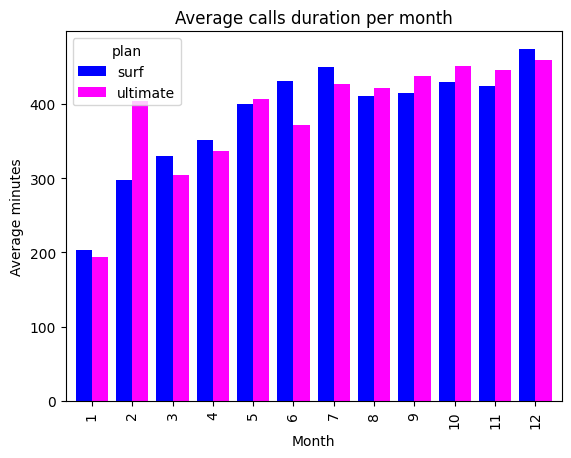

In [32]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

# Creando una DF con una tabla pivote que calcula la media de los minutos consumidos por cada plan por cada mes.
calls_average_duration = users_consumption_df.pivot_table(index='month',
                                                          columns='plan',
                                                          values='minutes_month',
                                                          aggfunc='mean')

# Creando gráico de barras que compara la información de tipos de planes con la información de nuestro DF
calls_average_duration.plot(kind='bar',
                            xlabel='Month',
                            ylabel='Average minutes',
                            title='Average calls duration per month',
                            width=0.8,
                            color=['blue','magenta'])

plt.show()

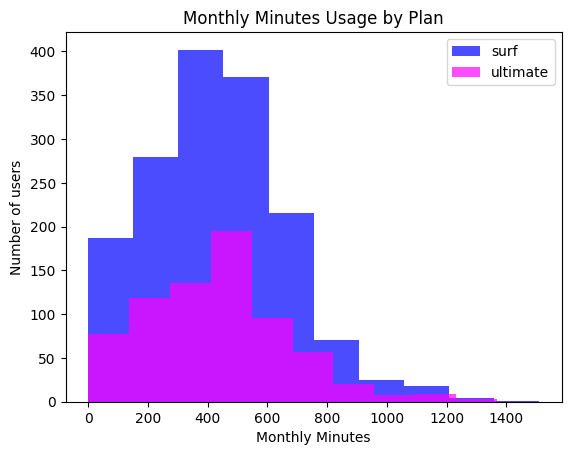

In [33]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

# Filtrando el DataFrame por plan y minutos consumidos por mes.
minutes_surf = users_consumption_df[users_consumption_df['plan'] == 'surf']['minutes_month']
minutes_ultimate = users_consumption_df[users_consumption_df['plan'] == 'ultimate']['minutes_month']

# Creando el histograma
plt.hist(minutes_surf, bins=10, alpha=0.7, label='surf', color='blue')
plt.hist(minutes_ultimate, bins=10, alpha=0.7, label='ultimate', color='magenta')

plt.title('Monthly Minutes Usage by Plan')
plt.xlabel('Monthly Minutes')
plt.ylabel('Number of users')
plt.legend()

plt.show()


[Calcula la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.]

In [34]:
# Filtrando DFs por plan
surf_consumption = users_consumption_df[users_consumption_df['plan']=='surf']
ultimate_consumption = users_consumption_df[users_consumption_df['plan']=='ultimate']

In [51]:
# Calcula la media y la varianza de la duración mensual de llamadas.

# Calculo de media y varianza de los minutos de llamadas general
calls_duration_mean = users_consumption_df['minutes_month'].mean()
calls_duration_variance = np.var(users_consumption_df['minutes_month'])

# Calculo de medias por plan
surf_duration_mean = surf_consumption['minutes_month'].mean()
ultimate_duraton_mean = ultimate_consumption['minutes_month'].mean()

# Calculo de varianzas por plan
surf_duration_std_dev = np.var(surf_consumption['minutes_month'])
ultimate_duration_std_dev = np.var(ultimate_consumption['minutes_month'])

print('Media de la duración mensual de llamadas\nGeneral:',round(calls_duration_mean,3),'\nSurf:',round(surf_duration_mean,3),'\nUltimate:',round(ultimate_duraton_mean,3),'\n')
print('Varianza de la duración mensual de llamadas\nGeneral:',round(calls_duration_variance,3),'\nSurf:',round(surf_duration_std_dev,3),'\nUltimate:',round(ultimate_duration_std_dev,3))


Media de la duración mensual de llamadas
General: 429.283 
Surf: 428.75 
Ultimate: 430.45 

Varianza de la duración mensual de llamadas
General: 55822.823 
Surf: 54933.335 
Ultimate: 57764.125


In [36]:
# Cálculo de las medias de número de llamadas por plan

# Calculo de media y varianza de los minutos de llamadas general
calls_mean = users_consumption_df['calls_month'].mean()

# Calculo de medias por plan
surf_calls_mean = surf_consumption['calls_month'].mean()
ultimate_calls_mean = ultimate_consumption['calls_month'].mean()

print('Media de numero mensual de llamadas\nGeneral:',round(calls_mean,3),'\nSurf:',round(surf_calls_mean,3),'\nUltimate:',round(ultimate_calls_mean,3),'\n')

Media de numero mensual de llamadas
General: 60.068 
Surf: 59.812 
Ultimate: 60.626 



<Axes: ylabel='minutes_month'>

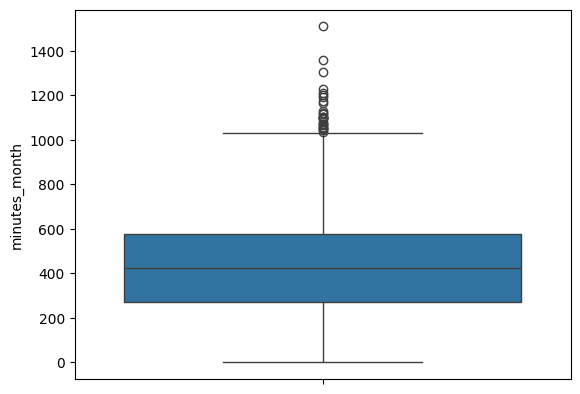

In [37]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
#sns.boxplot(users_consumption_df['minutes_month'])
sns.boxplot(surf_consumption['minutes_month'])
#sns.boxplot(ultimate_consumption['minutes_month'])

El comportamiento de los usuarios respecto a las llamadas es en general el mismo. El promedio mensual de duración de llamadas es de 429 min, 429 min en el plan Surf y 430 en el plan Ultimate. 

Si bien la mayor parte de los meses la duración de llamadas es la misma entre ambos planes o incluso la duración es inferior para aquellos usuarios en el plan Ultimate, en el mes de febrero (2) podemos observar que hubo un incremento sustancial para la duración de llamadas de Ultimate, el comportamineto de este mes es lo que hace que el promedio de la duración de llamadas de Ultimate sea superior a Surf. 

También vale la pena mencionar que existen bastantes excepciones en la duración de llamadas de los usuarios del plan Surf y que dependiendo de cual sea su cobro mensual contemplando sus excesos podría valer la pena cambiarse a un plan Ultimate.

De igual manera, para los usuarios del plan Ultimate parece que solo algunos de ellos consumen más de la media de 430min, por lo cual en el caso de las llamadas a la mayoría de los usuarios de este plan no les conviene estar en este plan.

En conclusión, los usuarios en promedio consumen la misma cantidad de minutos, generalmente los usuarios de Surf consumen más minutos durante el mes pero existen excepciones, y en general ninguno de los dos grupos excede la capacidad de sus planes.

### Mensajes

<Axes: title={'center': 'Messages sent per month'}, xlabel='Month', ylabel='Messages per month'>

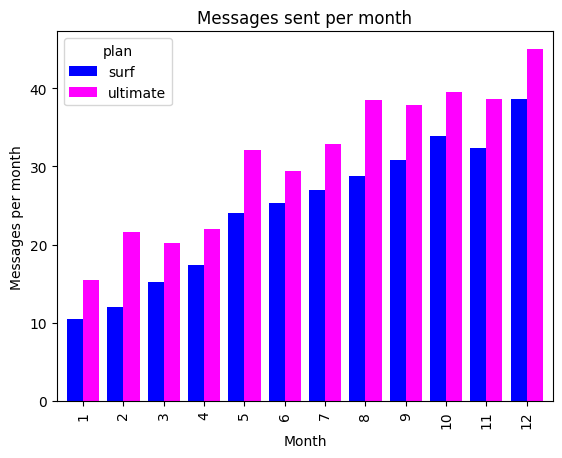

In [38]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
messages_pivot = users_consumption_df.pivot_table(index='month',
                                                  columns='plan',
                                                  values='messages_month')

messages_pivot.plot(kind='bar',xlabel='Month',ylabel='Messages per month',title='Messages sent per month',width=0.8,color=['blue','magenta'])

In [39]:
# Calcula la media y la varianza de los mensajes enviados mensualmente

# Cálculos de medias
messages_mu = users_consumption_df['messages_month'].mean() 
messages_mu_surf = surf_consumption['messages_month'].mean()
messages_mu_ultimate = ultimate_consumption['messages_month'].mean()

# Cálculos de varianzas
messages_std_dev = np.var(users_consumption_df['messages_month']) # varianza de mensajes enviados general
surf_messages_std_dev = np.var(surf_consumption['messages_month']) # varianza de mensajes enviados de surf
ultimate_messages_std_dev = np.var(ultimate_consumption['messages_month']) #varianza de mensajes enviados de ultimate

print('Media de mensajes enviados al mes\nGeneral:',round(messages_mu,3),'\nSurf:',round(messages_mu_surf,3),'\nUltimate:',round(messages_mu_ultimate,3),'\n')
print('Varianza de mensajes enviados al mes\nGeneral:',round(messages_std_dev,3),'\nSurf:',round(surf_messages_std_dev,3),'\nUltimate:',round(ultimate_messages_std_dev,3))

Media de mensajes enviados al mes
General: 33.167 
Surf: 31.16 
Ultimate: 37.551 

Varianza de mensajes enviados al mes
General: 1160.264 
Surf: 1126.008 
Ultimate: 1207.078


<Axes: ylabel='messages_month'>

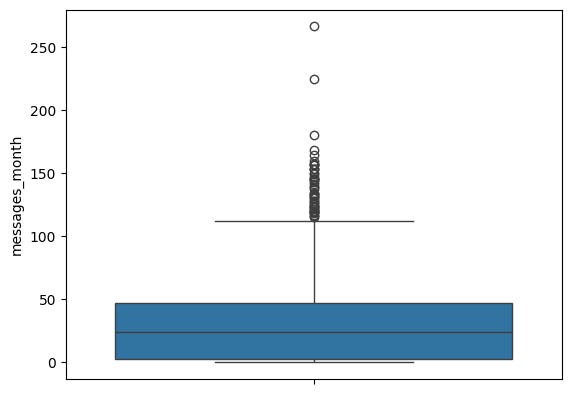

In [40]:
# Traza un diagrama de caja para visualizar la distribución los mensajes enviados mensualmente
#sns.boxplot(users_consumption_df['messages_month'])
sns.boxplot(surf_consumption['messages_month'])
#sns.boxplot(ultimate_consumption['messages_month'])

El comportamiento de los usuarios con respecto en general la cantidad de mensajes enviados por mes es superior para los usuarios del plan Ultimate. 
En promedio se mandan 33 mensajes al mes, 31 para el plan Surf y 38 para el plan Ultimate.

Existe una cantidad significante de excepciones y en el caso del plan Surf hay bastantes usuarios que envían más de 50 mensajes al mes en promedio. En este caso vadría la pena considerar aumentar su plan a un Ultimate en caso de que el cargo por este excedente compense los $50 extras.

En general los usuarios del plan Ultimate sí mandan más mensajes que los usuarios del plan Surf, pero solo en el mes de diciembre (12) este promedio supera 50 mensajes, por lo general parece que la mayoría de los usuarios Ultimate no necesitarían este plan.

### Internet

<Axes: title={'center': 'Internet consumed per month'}, xlabel='Month', ylabel='GB consumed'>

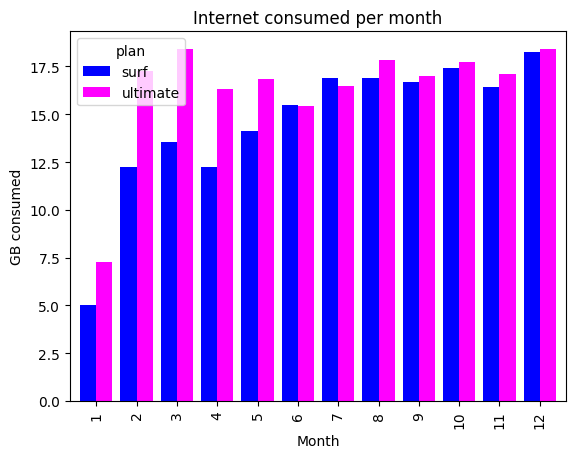

In [41]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan

internet_pivot = users_consumption_df.pivot_table(index='month',
                                               columns='plan',
                                               values='gb_month')

internet_pivot.plot(kind='bar',xlabel='Month',ylabel='GB consumed',title='Internet consumed per month',width=0.8,color=['blue','magenta'])


In [42]:
# Calcula la media y la varianza de los gigabytes consumidos mensualmentes

# Cálculos de medias
internet_consumption_mu = users_consumption_df['gb_month'].mean()  # media general
internet_mu_surf = surf_consumption['gb_month'].mean()
internet_mu_ultimate = ultimate_consumption['gb_month'].mean()

# Cálculos de varianzas
internet_consumption_std_dev = np.var(users_consumption_df['gb_month']) # varianza de mensajes enviados general
surf_internet_std_dev = np.var(surf_consumption['gb_month']) # varianza de mensajes enviados de surf
ultimate_internet_std_dev = np.var(ultimate_consumption['gb_month']) #varianza de mensajes enviados de ultimate

print('Media del internet consumido por mes\nGeneral:',round(internet_consumption_mu,3),'\nSurf:',round(internet_mu_surf,3),'\nUltimate:',round(internet_mu_ultimate,3),'\n')
print('Varianza del internet consumido por mes\nGeneral:',round(internet_consumption_std_dev,3),'\nSurf:',round(surf_internet_std_dev,3),'\nUltimate:',round(ultimate_internet_std_dev,3))



Media del internet consumido por mes
General: 16.87 
Surf: 16.671 
Ultimate: 17.307 

Varianza del internet consumido por mes
General: 60.754 
Surf: 61.544 
Ultimate: 58.749


<Axes: ylabel='gb_month'>

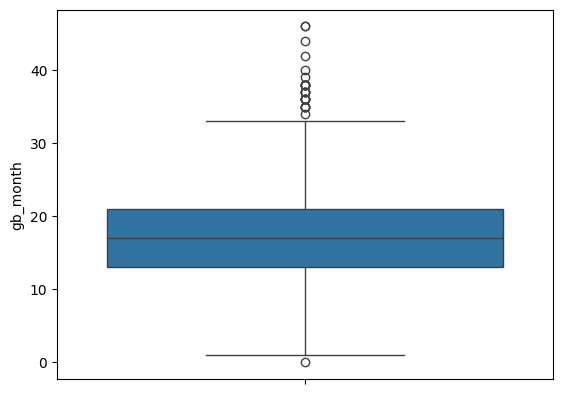

In [43]:
#sns.boxplot(users_consumption_df['gb_month'])
#sns.boxplot(surf_consumption['gb_month'])
sns.boxplot(ultimate_consumption['gb_month'])

El comportamiento de los usuarios con respecto a los gigabytes consumidos, podemos observar que pocas veces los usuarios del plan Surf consumen máximo 15gb parece que solo los primeros meses del año se mantienen al margen de lo que su plan incluye, gen general sí, los usuarios del plan Ultimate consumen más internet que los usuarios Surf que tiene sentido.

En promedio los usuarios consumen 16.97gb al mes, los usuarios Surf consumen 16.67gb y los usuarios Ultimate 17.30. 
El promedio de los datos consumidos por el plan Surf no tiene sentido, parece que en promedio estos usuarios pagan como mínimo $20 extras cada mes. A su vez parece que los usuarios Ultimate raras veces consumen más internet del incluido en sus planes, e inclusive consumen mucho menos internet del que tienen disponible.

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

<Axes: title={'center': 'Income per month'}, xlabel='Month', ylabel='Income'>

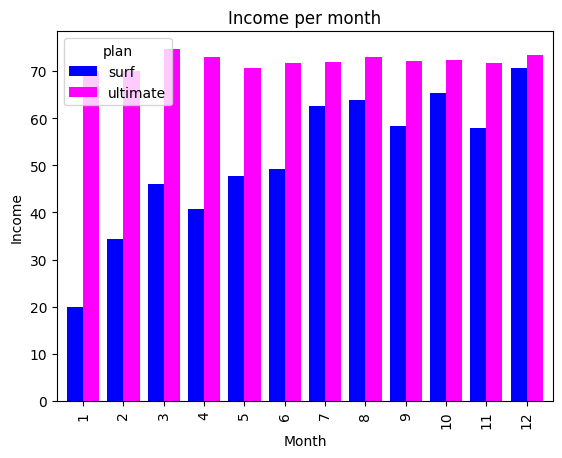

In [44]:
income_pivot = users_consumption_df.pivot_table(index='month',
                                               columns='plan',
                                               values='total_charge')

income_pivot.plot(kind='bar',xlabel='Month',ylabel='Income',title='Income per month',width=0.8,color=['blue','magenta'])


In [45]:
# Calcula la media y la varianza de los gigabytes consumidos mensualmentes

# Cálculos de medias
income_mu = users_consumption_df['total_charge'].mean()
income_mu_surf = surf_consumption['total_charge'].mean()
income_mu_ultimate = ultimate_consumption['total_charge'].mean()

# Cálculos de varianzas
income_std_dev = np.var(users_consumption_df['total_charge'])
surf_income_std_dev = np.var(surf_consumption['total_charge']) # varianza de mensajes enviados de surf
ultimate_income_std_dev = np.var(ultimate_consumption['total_charge']) #varianza de mensajes enviados de ultimate


print('Media de los ingresos mensuales\nGeneral:',round(income_mu,3),'\nSurf:',round(income_mu_surf,3),'\nUltimate:',round(income_mu_ultimate,3),'\n')
print('Varianza de los ingresos mensuales\nGeneral:',round(income_std_dev,3),'\nSurf:',round(surf_income_std_dev,3),'\nUltimate:',round(ultimate_income_std_dev,3))

Media de los ingresos mensuales
General: 64.351 
Surf: 60.706 
Ultimate: 72.314 

Varianza de los ingresos mensuales
General: 2172.937 
Surf: 3065.885 
Ultimate: 129.668


<Axes: ylabel='total_charge'>

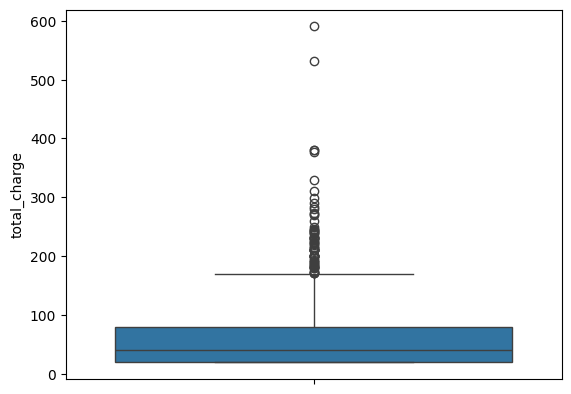

In [46]:
#sns.boxplot(users_consumption_df['total_charge'])
sns.boxplot(surf_consumption['total_charge'])
#sns.boxplot(ultimate_consumption['total_charge'])

En el caso de los ingresos de los usuarios, el promedio general es de $64, para los usuarios de Surf es de $61 ($41 más que su plan) y para los usuarios Ultimate el promedio es de $72.

En este caso es claro que el grupo de usuarios Ultimate tiene un ingreso mayor a los usuarios Surf durante todo el año, pero curiosmente su promedio respectivo no está tan alejado uno del otro. Esto se debe a que para los ingresos de los usuarios Ultimate existe una variación estándar muy baja 129, sobretodo en comparación a la desviación estándar del grupo de usuarios Surf de 3,065, esto significa que existe una gran cantidad de usuarios que gastan incluso más que estos $61 promedios. 

## Prueba las hipótesis estadísticas

Nuestra hipótesis nula es confirmar si los ingresos promedio procedentes de los usuarios de los planes Ultimate y Surf son similares.
Establecemos el nivel de significación en 0.05.

In [47]:
alpha = 0.05

results = st.ttest_ind(surf_consumption['total_charge'],ultimate_consumption['total_charge'],equal_var=False)

print('valor p:',results.pvalue*100,'%')

if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


valor p: 3.1703905481135736e-13 %
Rechazamos la hipótesis nula


Se rechaza la hipótesis nula, los ingresos de los usuarios de Ultimate y Surf son diferentes.

[Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.]

In [50]:
areas_looked_mask = users_consumption_df[users_consumption_df['area'].str.contains('NY-NJ')]['area'].unique() # filtrando el DF  por las áreas que contengan 'NY-NJ'

in_area = users_consumption_df[users_consumption_df['area'].isin(areas_looked_mask)]['total_charge'] # filtrando los ingresos dentro el área buscada
not_in_area = users_consumption_df[~users_consumption_df['area'].isin(areas_looked_mask)]['total_charge'] # filtrando los ingresos fuera el área buscada

# calculando las desviaciones estándar de cada filtro
in_area_std_dev = np.var(in_area)
not_in_area_std_dev = np.var(not_in_area)

# calculando las desviaciones estándar de cada filtro
in_area_std_dev = np.var(in_area)
not_in_area_std_dev = np.var(not_in_area)

# revisando la similitud de las desviaciones estándar de cada serie
print(in_area_std_dev)
print(not_in_area_std_dev)



1890.5177172681156
2223.8866958162175


Nuestra hipótesis nula es confirmar si el ingreso promedio de los usuarios del área NY-NJ es similar al de los usuarios de otras regiones.
Se establece el nivel de significación en 0.05.

In [49]:
# Prueba las hipótesis
test = st.ttest_ind(in_area,not_in_area,equal_var=True)

alpha = 0.05

print('valor p:',test.pvalue*100,'%')

if (test.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


valor p: 4.355743162134244 %
Rechazamos la hipótesis nula


El ingreso de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.

## Conclusión general 

En el caso de llamadas el comportamiento de los usuarios no varía significativamente de un plan a otro.
Para los mensajes los usuarios del plan Ultimate envían más mensajes que los usuarios del plan Surf y en promedio no consumen más de 50 mensajes en ninguno de los dos grupos.
En el caso de internet, tampoco existe una diferencia significativa entre la cantidad de gigabyes usados por plan pero, lo relevante de este punto es que los usuarios del plan Surf consumen en promedio ~2gb más de lo que su plan incluye.
Y finalmente para los ingresos, a primera vista los ingresos de ambos grupos son similares en promedio, pero, cuando revisamos la desviación estándar nos damos cuenta que realmente existen bastantes usuarios que se alejan de la media y que probablemente muevan este promedio hacia arriba, también cuando realizamos un t-test para probar la similitud entre estos dos grupos nos encontramos con que se rechaza la hipótesis nula, que quiere decir que los ingresos de ambos grupos son diferentes.

En general consideramos que Megaline podría ofrecer únicamente estos dos planes por propia conveniencia puesto que si se creara un tercero plan 'X' con una cantidad de 20gb para internet, 100 mensajes y 1,000 minutos de llamadas por digamos $40 la mayoría de sus usuarios se moverían a este plan y esto podría traer consecuencias negativas para los ingresos de Megaline pues la mayoría de clientes de plan Ultimate no consumen todo lo que incluye su plan y los usuarios del plan Surf también se moverían a este plan y dejarían de recibir $20 extras cada mes. Esto se tendría que estudiar más en un ejercicio dedicado para este tema. Otro punto a considerar con esta información es que si existe competencia que se de cuenta que existe un mercado potencial para las cifras del plan 'X' podrían crear una competencia bastante fuerte para Megaline.
